In [20]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(1882)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
XY = np.loadtxt('rp.data')
XY = XY.astype(np.int8)
df = pd.DataFrame(XY, columns=[f'x{i}' for i in range(1, XY.shape[1])] + ['y'])
correlation_matrix = df.corr()

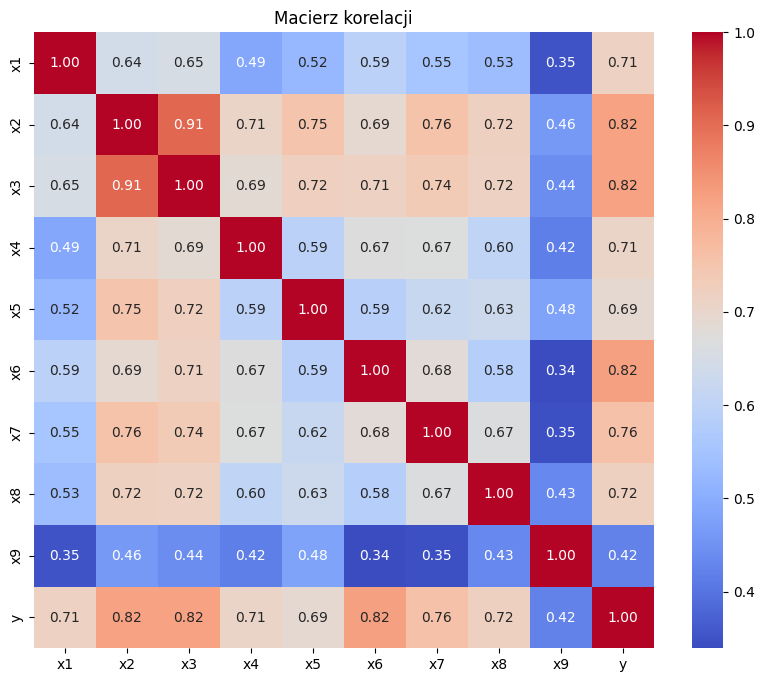

In [22]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Macierz korelacji')
plt.show()

Widzimy, że x2, x3, x6 są skorelowane z y. Być może jest to błędne wnioskowanie, ponieważ y tutaj ma formę {2, 4} a nie {0, 1}, ale zobaczymy...  
Dodatkowo pokazują się pewne zależności między cechami np. x2 i x3, ciekawe co na to nasz naiwny Bayes ;)  
Ale przed tym, przegląd wykresów, które zasugerował ChatGPT

<Figure size 1000x800 with 0 Axes>

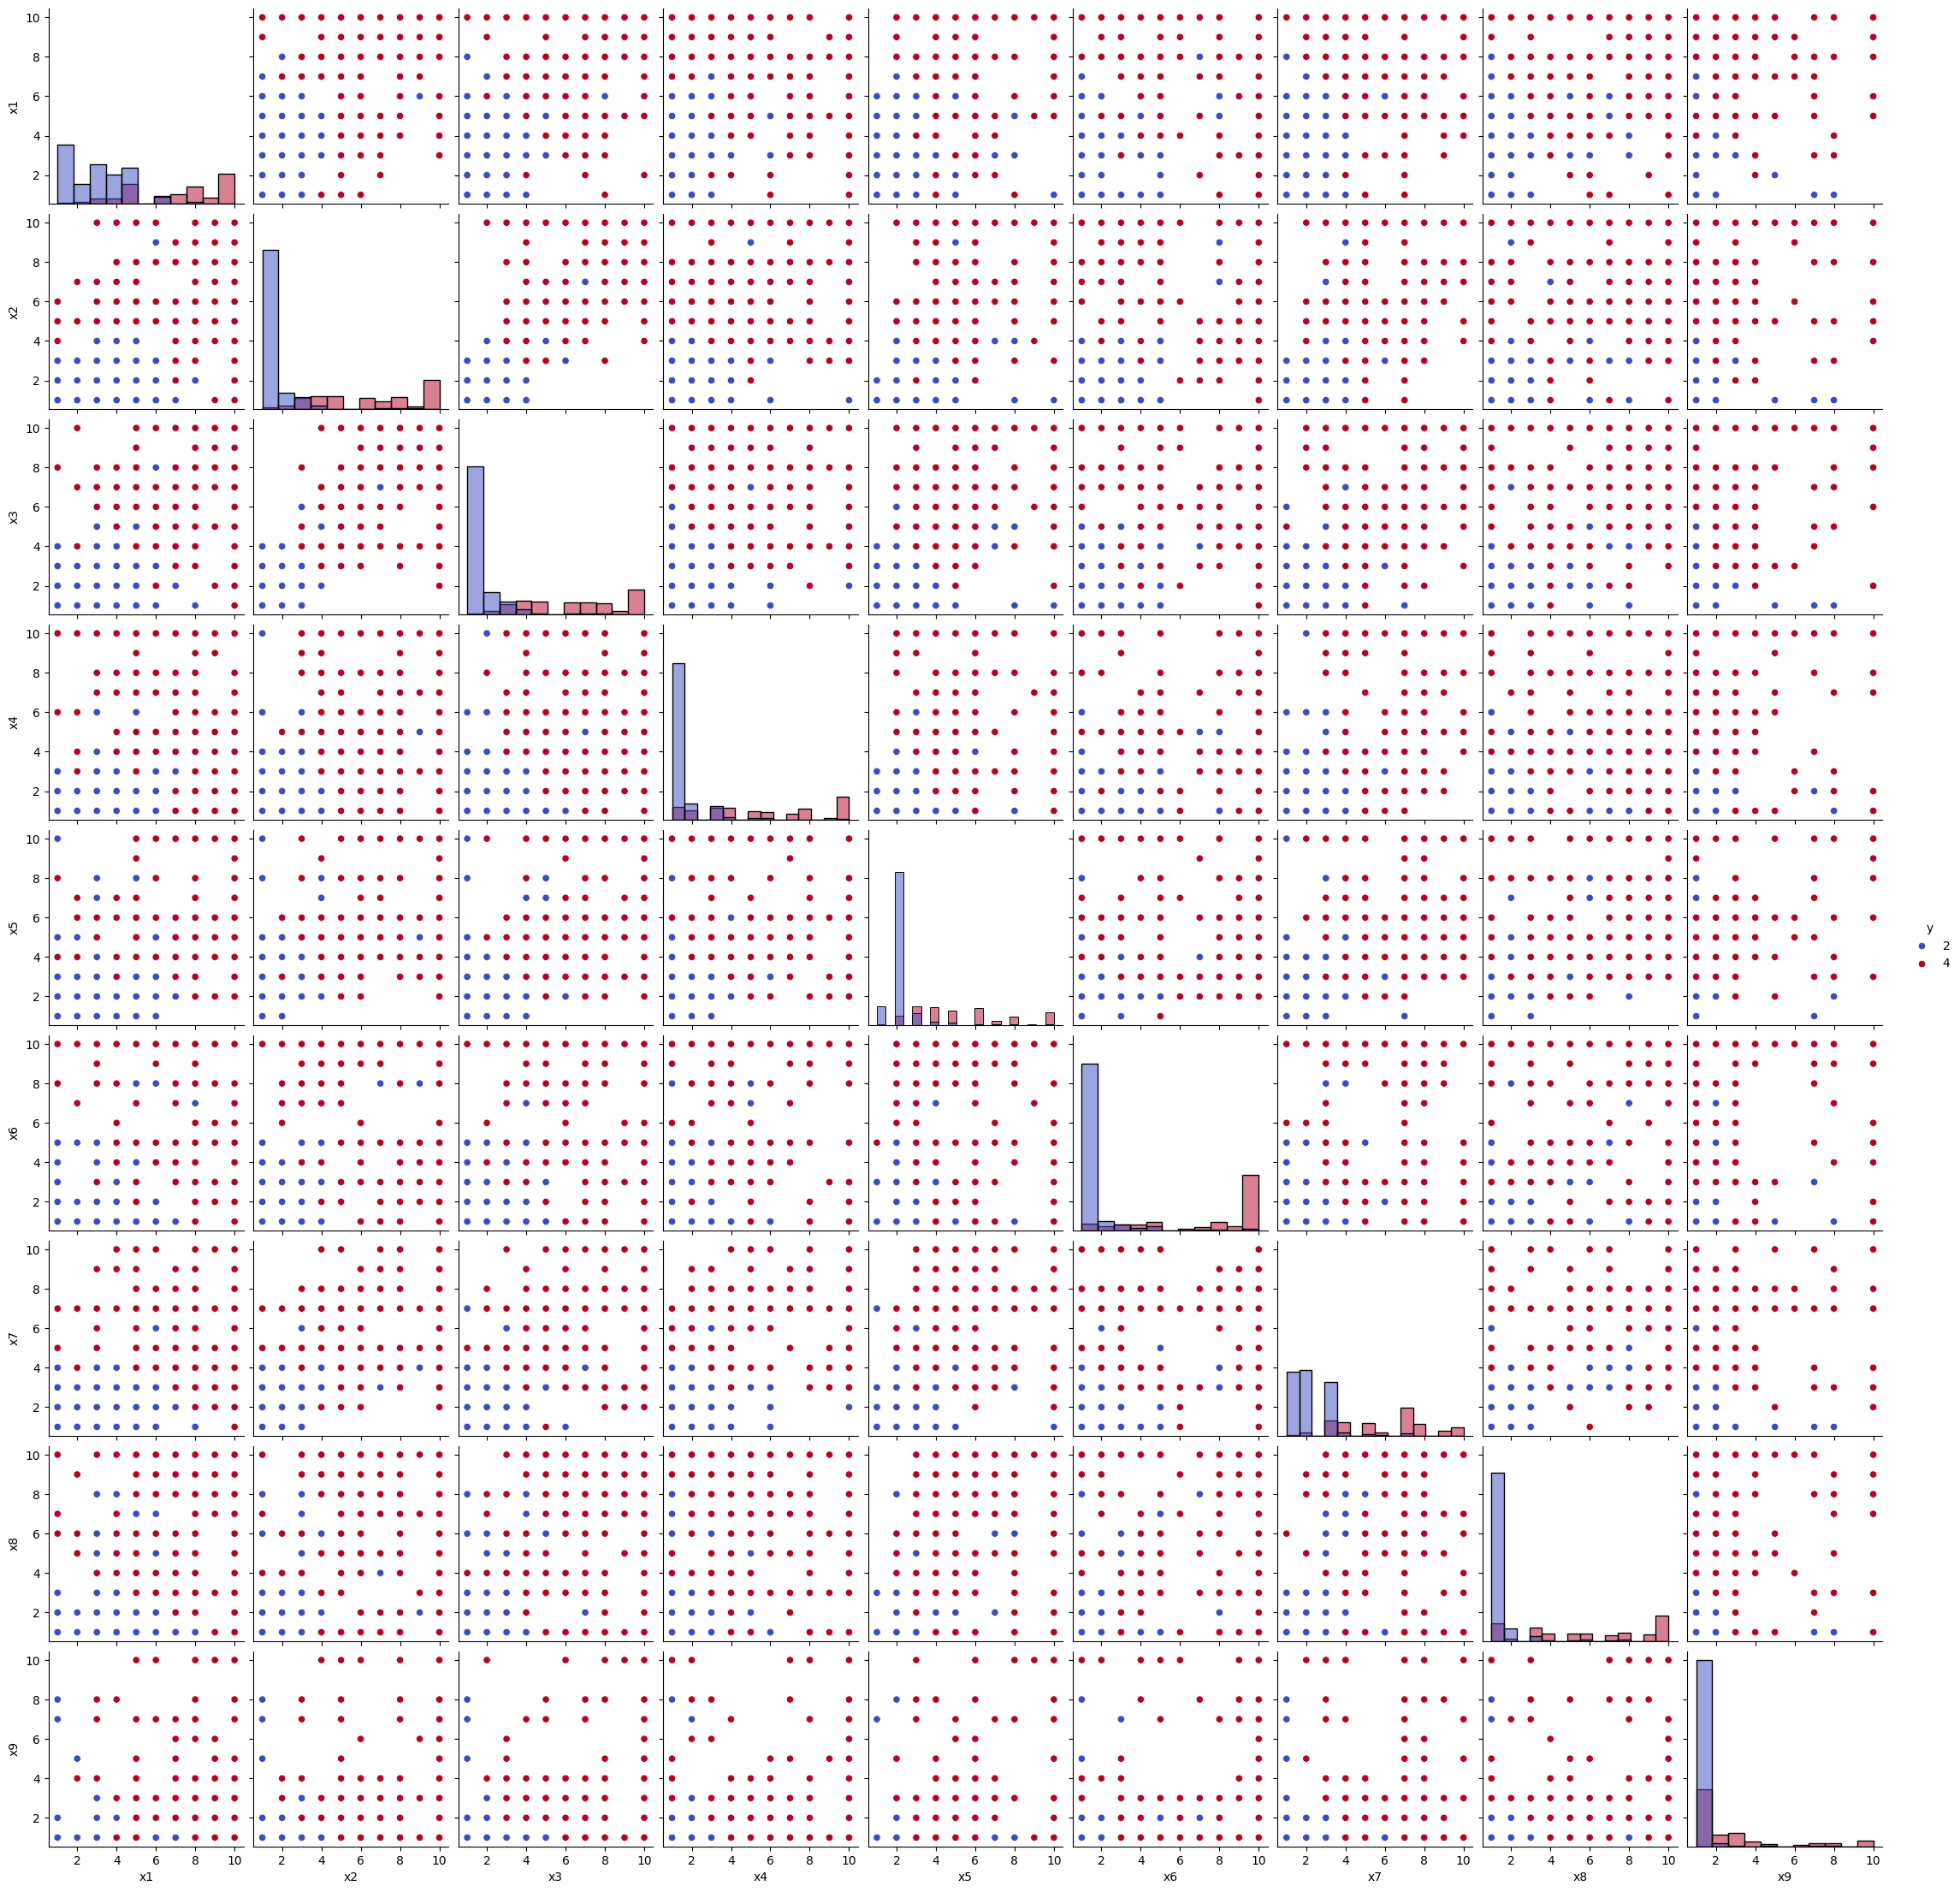

In [23]:
plt.figure(figsize=(10, 8))
sns.pairplot(df, hue='y', palette='coolwarm', diag_kind='hist')
plt.show()

Ten wykres jest dość duży, lepiej go oglądać jako zapisany obrazek.  
Z grubsza widzimy, że jeśli y = 2 to cechy < 5.  
Dodatkowo każda para jest na oko liniowo seperowalna, jeszcze nie do końca wiem jak się to przełoży na liniową separowalność wszystkich cech.

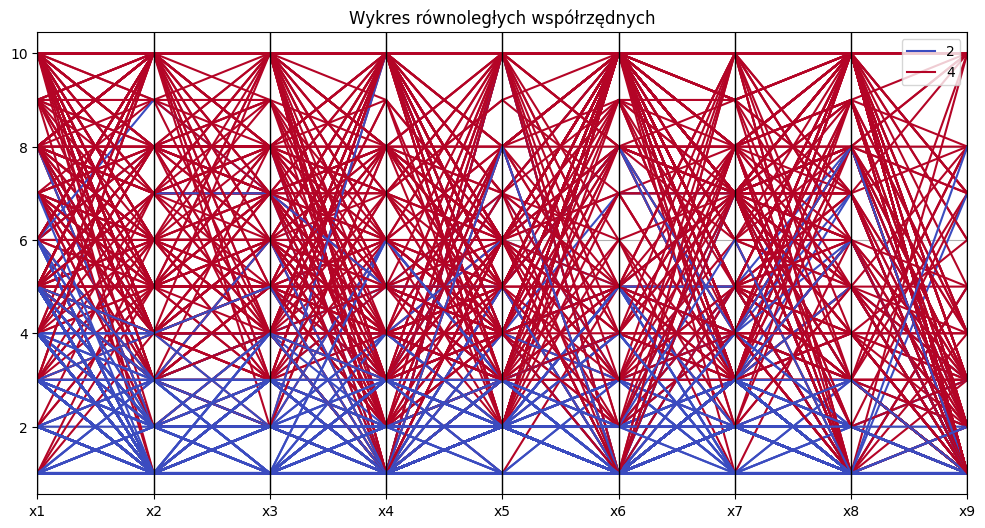

In [24]:
from pandas.plotting import parallel_coordinates

plt.figure(figsize=(12, 6))
parallel_coordinates(df, class_column='y', colormap='coolwarm')
plt.title('Wykres równoległych współrzędnych')
plt.show()

Potwierdza, się to co zauważyliśmy wcześniej.

In [25]:
from utilz import divide_dataset

T = 10 # numer of iterations
R = 7 # chosen iteration

# and some constants
EPOCHS = 1000
EPSILON = 1e-5

datasets = []
for i in range(T):
    datasets.append(
        divide_dataset(
            XY.copy(),
            fractions_train_val_test=[0.67, 0.0, 0.33]))

Sanity check, czy klasy są równo rozłożone

In [26]:
from collections import Counter

U, _, V = datasets[R]

xy_c = Counter(XY[:, -1])
u_c = Counter(U[:, -1])
v_c = Counter(V[:, -1])

print(f'Class 2 ratio in train set: {u_c[2] / xy_c[2]:.2f}')
print(f'Class 4 ratio in train set: {u_c[4] / xy_c[4]:.2f}')
print(f'Class 2 ratio in test set: {v_c[2] / xy_c[2]:.2f}')
print(f'Class 4 ratio in test set: {v_c[4] / xy_c[4]:.2f}')


Class 2 ratio in train set: 0.67
Class 4 ratio in train set: 0.67
Class 2 ratio in test set: 0.33
Class 4 ratio in test set: 0.33


Zaczynamy od naiwnego Bayesa.  
Teraz nie wpadnę już w klątwę parametryzacji wielkiej funkcji :)

In [27]:
from classification import NaiveBayes
from measures import average_error

bayes = NaiveBayes()
bayes_average_error, bayes_average_training_error = average_error(bayes, datasets)

print(f'Naive Bayes average error: {bayes_average_error:.4f}')
print(f'Naive Bayes average training error: {bayes_average_training_error:.4f}')


Naive Bayes average error: 0.0261
Naive Bayes average training error: 0.0230


Sprawdźmy ze SciKitem

In [28]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import zero_one_loss
from utilz import split_data

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

sklearn_bayes = MultinomialNB(alpha=1.0, fit_prior=True)
sklearn_bayes.fit(X_train_r, y_train_r.ravel())
sklearn_bayes_error = zero_one_loss(y_test_r.ravel(), sklearn_bayes.predict(X_test_r))
sklearn_bayes_training_error = zero_one_loss(y_train_r.ravel(), sklearn_bayes.predict(X_train_r))
print(f'Sklearn Naive Bayes error: {sklearn_bayes_error:.4f}')
print(f'Sklearn Naive Bayes training error: {sklearn_bayes_training_error:.4f}')

Sklearn Naive Bayes error: 0.1283
Sklearn Naive Bayes training error: 0.0788


In [44]:
from classification import NaiveBayes

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

bayes = NaiveBayes()
bayes.fit(X_train_r, y_train_r)
bayes_error = bayes.zero_one_error(X_test_r, y_test_r)
bayes_training_error = bayes.zero_one_error(X_train_r, y_train_r)
print(f'Naive Bayes error: {bayes_error:.4f}')
print(f'Naive Bayes training error: {bayes_training_error:.4f}')


Naive Bayes error: 0.0221
Naive Bayes training error: 0.0241


Co tu się dzieje, czemu mój Bayes jest lepszy???  
Być może ja posiadam wiem więcej o danych niż SciKit.

In [30]:
print(f'Class probabilities sklearn: {np.exp(sklearn_bayes.class_log_prior_)}')
print(f'Class probabilities Naive Bayes: {bayes.class_mle}')

Class probabilities sklearn: [0.64989059 0.35010941]
Class probabilities Naive Bayes: [0.64923747 0.35076253]


Hmm... klasy działają, zobaczmy cechy

In [31]:
print(f'Feature probabilities sklearn:\n{np.exp(sklearn_bayes.feature_log_prob_)}')
print()
print(f'Feature probabilities Naive Bayes:\n{bayes.feature_mle}')

Feature probabilities sklearn:
[[0.19881845 0.08816178 0.0927062  0.08975233 0.14246762 0.08657123
  0.14269484 0.08611679 0.07271075]
 [0.13327815 0.121807   0.12429044 0.10596026 0.09874645 0.14155629
  0.11376537 0.11412015 0.04647588]]

Feature probabilities Naive Bayes:
[array([[0.29967427, 0.10423453, 0.21172638, 0.15635179, 0.16612378,
        0.03583062, 0.00651466, 0.01302932, 0.00325733, 0.00325733],
       [0.81107492, 0.08794788, 0.05863192, 0.01302932, 0.00325733,
        0.00325733, 0.00651466, 0.00651466, 0.00651466, 0.00325733],
       [0.77198697, 0.11074919, 0.06514658, 0.01954397, 0.00325733,
        0.00651466, 0.00977199, 0.00651466, 0.00325733, 0.00325733],
       [0.78501629, 0.09446254, 0.0781759 , 0.01302932, 0.00651466,
        0.00977199, 0.00325733, 0.00325733, 0.00325733, 0.00325733],
       [0.09446254, 0.7752443 , 0.07166124, 0.01302932, 0.01954397,
        0.00651466, 0.00325733, 0.00651466, 0.00325733, 0.00651466],
       [0.85993485, 0.05211726, 0.0293

Chyba rozumiem, SciKit zakłada, że jest 9 cech 0-1, a w rzeczywistości jest 9 cech {1..10}.  
Jak już rozumiemy, że założenia o rozkładzie są bardzo ważne to popatrzmy jak szybko się to uczy.  
Czasowo i asymptotycznie ;)

In [32]:
from classification import NaiveBayes
from measures import average_fit_time

bayes = NaiveBayes()
bayes_average_fit_time = average_fit_time(bayes, datasets)
print(f'Naive Bayes average fit time: {bayes_average_fit_time:.7f} seconds')

Naive Bayes average fit time: 0.0001649 seconds


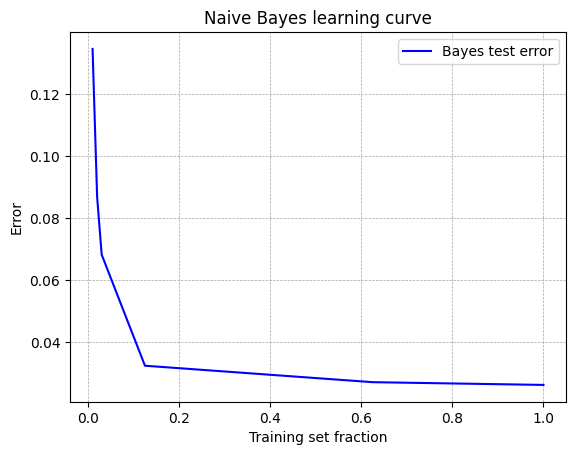

In [33]:
from classification import NaiveBayes
from measures import learning_curve

training_set_fractions = [0.01, 0.02, 0.03, 0.125, 0.625, 1]

bayes = NaiveBayes()
bayes_test_errors = learning_curve(bayes, datasets, training_set_fractions)

fig, ax = plt.subplots()
ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
sns.lineplot(
    x = training_set_fractions, y = bayes_test_errors,
    ax = ax, label='Bayes test error', color='blue')
ax.set(xlabel='Training set fraction', ylabel='Error')
ax.set_title('Naive Bayes learning curve')
plt.legend()

Teraz możemy coś sprawdzić z artykułem.  
? 0.12 * m ~ log(n) ?
? 55 ~ log(9) ?  
Coś się nie chce zgodzić :(  
Pewnie przez stałe

Ok, spójrzmy sobie na dokładność, precyzję i czułość

In [48]:
from classification import NaiveBayes

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

bayes = NaiveBayes()
bayes.fit(X_train_r, y_train_r)
bayes_accuracy = bayes.accuracy(X_test_r, y_test_r)
bayes_precision = bayes.precision(X_test_r, y_test_r)
bayes_sensitivity = bayes.sensitivity(X_test_r, y_test_r)
print(f'Naive Bayes accuracy: {bayes_accuracy:.4f}')
print(f'Naive Bayes precision: {bayes_precision:.4f}')
print(f'Naive Bayes sensitivity: {bayes_sensitivity:.4f}')


Naive Bayes accuracy: 0.9779
Naive Bayes precision: 0.9405
Naive Bayes sensitivity: 1.0000


Nie ma co robić :)  
Z racji tego, że to jest rak, zależałoby nam na wysokiej czułości  
No i ją mamy  
Ale pobawmy się granicą decyzyjną, może wyciągniemy coś lepszego z tego Bayesa

In [81]:
from classification import NaiveBayes

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

bayes = NaiveBayes(boundary=0.9999)
bayes.fit(X_train_r, y_train_r)
bayes_accuracy = bayes.accuracy(X_test_r, y_test_r)
bayes_precision = bayes.precision(X_test_r, y_test_r)
bayes_sensitivity = bayes.sensitivity(X_test_r, y_test_r)
print(f'Naive Bayes accuracy: {bayes_accuracy:.4f}')
print(f'Naive Bayes precision: {bayes_precision:.4f}')
print(f'Naive Bayes sensitivity: {bayes_sensitivity:.4f}')


Naive Bayes accuracy: 0.9469
Naive Bayes precision: 0.9467
Naive Bayes sensitivity: 0.8987


Rzeczywiście jesteśmy w stanie zmienić precyzję granicą decyzyjną, ale ten Bayes bardzo dobrze rozróżnia  
Poniżej prawdopodobieństwa a posteriori  
```
0.0002501727910187334
0.9999955799911749
0.9999999999910805
0.999999999724131
3.95165834865358e-09
0.0002159627418231111
0.9999999988067703
3.95165834865358e-09
0.9999999995439866
1.7258835065009394e-08
```

Czas na regresję logistyczną.  
Wybrałem sobie wariant:  
- intercept (bo czemu nie)
- standaryzacja
- zwykły GD (alpha = 0.1 z poprzedniego miniprojektu)
- L2

In [289]:
from classification import LogisticRegression
from gradient import GradientDescent

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

regression = LogisticRegression(grad=GradientDescent(), standardize=False, alpha=0.01, epochs=2000, fit_intercept=False)
regression.fit(X_train_r, y_train_r)
print(f'Logistic regression binary cross entropy test: {regression.binary_cross_entropy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression binary cross entropy train: {regression.binary_cross_entropy(X_train_r, y_train_r):.4f}')


Logistic regression binary cross entropy test: 0.4601
Logistic regression binary cross entropy train: 0.3573


Szybki sanity check z SciKitem

In [290]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import log_loss

model = SklearnLogisticRegression(penalty=None, fit_intercept=False)
model.fit(X_train_r, y_train_r.ravel())
sk_log_loss = log_loss(y_test_r.ravel(), model.predict_proba(X_test_r))
print(f'Sklearn logistic regression binary cross entropy test: {sk_log_loss:.4f}')

sk_train_log_loss = log_loss(y_train_r.ravel(), model.predict_proba(X_train_r))
print(f'Sklearn logistic regression binary cross entropy train: {sk_train_log_loss:.4f}')

Sklearn logistic regression binary cross entropy test: 0.4625
Sklearn logistic regression binary cross entropy train: 0.3565


Interesujące wyniki otrzymuje

In [291]:
print(f'Sklearn logistic regression coefficients:\n{model.coef_.ravel()}')
print(f'Sklearn logistic regression intercept: {model.intercept_}')
print(f'Logistic regression coefficients:\n{regression.theta.ravel()}')
print(f'Logistic regression intercept: {regression.intercept}')

Sklearn logistic regression coefficients:
[-0.43756738  0.66289205  0.49255283  0.22878885 -0.670637    0.63980636
 -0.67859533  0.38356446 -0.38961885]
Sklearn logistic regression intercept: [0.]
Logistic regression coefficients:
[-0.42323982  0.57821453  0.48645523  0.19968235 -0.61766528  0.59913763
 -0.60769628  0.35594655 -0.35891101]
Logistic regression intercept: 0.0


In [292]:
print(f'Logistic regression error: {regression.zero_one_error(X_test_r, y_test_r):.4f}')
print(f'Logistic regression training error: {regression.zero_one_error(X_train_r, y_train_r):.4f}')

Logistic regression error: 0.1681
Logistic regression training error: 0.1138


In [293]:
print(f'Logistic regression accuracy: {regression.accuracy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression precision: {regression.precision(X_test_r, y_test_r):.4f}')
print(f'Logistic regression sensitivity: {regression.sensitivity(X_test_r, y_test_r):.4f}')

Logistic regression accuracy: 0.8319
Logistic regression precision: 0.7303
Logistic regression sensitivity: 0.8228


In [294]:
print(f'SklearnLogisticRegression accuracy: {model.score(X_test_r, y_test_r.ravel()):.4f}')

SklearnLogisticRegression accuracy: 0.8274


Po długiej walce jest zadowalająco  
Wersja:
- bez intercept
- GD (alpha=0.01 epochs=2000)
- bez L2
- bez standaryzacji  

Można powiedzieć, że działam tak samo jak Sklearn

In [295]:
from classification import LogisticRegression
from gradient import GradientDescent

train_r, _, test_r = datasets[R]
X_train_r, y_train_r = split_data(train_r)
X_test_r, y_test_r = split_data(test_r)

regression = LogisticRegression(grad=GradientDescent(), standardize=False, alpha=0.1, epochs=100, fit_intercept=True)
regression.fit(X_train_r, y_train_r)
print(f'Logistic regression binary cross entropy test: {regression.binary_cross_entropy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression binary cross entropy train: {regression.binary_cross_entropy(X_train_r, y_train_r):.4f}')
print(f'Logistic regression error: {regression.zero_one_error(X_test_r, y_test_r):.4f}')
print(f'Logistic regression training error: {regression.zero_one_error(X_train_r, y_train_r):.4f}')
print(f'Logistic regression accuracy: {regression.accuracy(X_test_r, y_test_r):.4f}')
print(f'Logistic regression precision: {regression.precision(X_test_r, y_test_r):.4f}')
print(f'Logistic regression sensitivity: {regression.sensitivity(X_test_r, y_test_r):.4f}')

Logistic regression binary cross entropy test: 0.1028
Logistic regression binary cross entropy train: 0.0743
Logistic regression error: 0.0221
Logistic regression training error: 0.0284
Logistic regression accuracy: 0.9779
Logistic regression precision: 0.9405
Logistic regression sensitivity: 1.0000


In [296]:
from sklearn.linear_model import LogisticRegression as SklearnLogisticRegression
from sklearn.metrics import log_loss

model = SklearnLogisticRegression(penalty=None, fit_intercept=True)
model.fit(X_train_r, y_train_r.ravel())
sk_log_loss = log_loss(y_test_r.ravel(), model.predict_proba(X_test_r))
sk_train_log_loss = log_loss(y_train_r.ravel(), model.predict_proba(X_train_r))
print(f'Sklearn logistic regression binary cross entropy test: {sk_log_loss:.4f}')
print(f'Sklearn logistic regression binary cross entropy train: {sk_train_log_loss:.4f}')
print(f'SklearnLogisticRegression accuracy: {model.score(X_test_r, y_test_r.ravel()):.4f}')

Sklearn logistic regression binary cross entropy test: 0.1273
Sklearn logistic regression binary cross entropy train: 0.0647
SklearnLogisticRegression accuracy: 0.9823


In [297]:
print(f'Sklearn logistic regression coefficients:\n{model.coef_.ravel()}')
print(f'Sklearn logistic regression intercept: {model.intercept_}')
print(f'Logistic regression coefficients:\n{regression.theta.ravel()}')
print(f'Logistic regression intercept: {regression.intercept}')

Sklearn logistic regression coefficients:
[ 0.73383492 -0.24273958  0.21223606  0.63294586  0.17446672  0.62432737
  0.4733406   0.30563416  0.85410719]
Sklearn logistic regression intercept: [-12.25086215]
Logistic regression coefficients:
[0.45996961 0.19108757 0.25498545 0.37263173 0.16450871 0.58645513
 0.28328807 0.30597899 0.20115511]
Logistic regression intercept: -10.119099076434608


Wersja:  
- intercept
- GD (alpha=0.01, epochs=2000)
- bez L2
- bez standaryzacji  

Tutaj już nie działa  
Jest podejrzenie, że gradient nierówno schodzi  
i po usunięciu 1/m z interceptu jest OK  
Co ma dużo sensu, cały czas nie możemy się wbić w minimum  
Chyba to tak zostawię, albo klepnę normalizację gradientu

Notatki:  
- Moja regresja nie zbiegała, norma gradientu rosła -> Pomyliłem y_pred i y  
- Lambda = 10000 daje podejrzanie dobre wyniki  
- Martwi mnie intercept = 0 -> był boolem  